In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import matplotlib.colors as colors

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [3]:
figure_dir = os.path.join(repo_path, 'figures')
array_dir = os.path.join(repo_path, 'output', 'arrays', 'test_physical_lens')

In [4]:
pandeia_1 = np.load(os.path.join(array_dir, 'test_physical_lens_image_1.npy'))
pandeia_3 = np.load(os.path.join(array_dir, 'test_physical_lens_image_3.npy'))
pandeia_5 = np.load(os.path.join(array_dir, 'test_physical_lens_image_5.npy'))
pandeia_7 = np.load(os.path.join(array_dir, 'test_physical_lens_image_7.npy'))
pandeia_9 = np.load(os.path.join(array_dir, 'test_physical_lens_image_9.npy'))
pandeia_11 = np.load(os.path.join(array_dir, 'test_physical_lens_image_11.npy'))

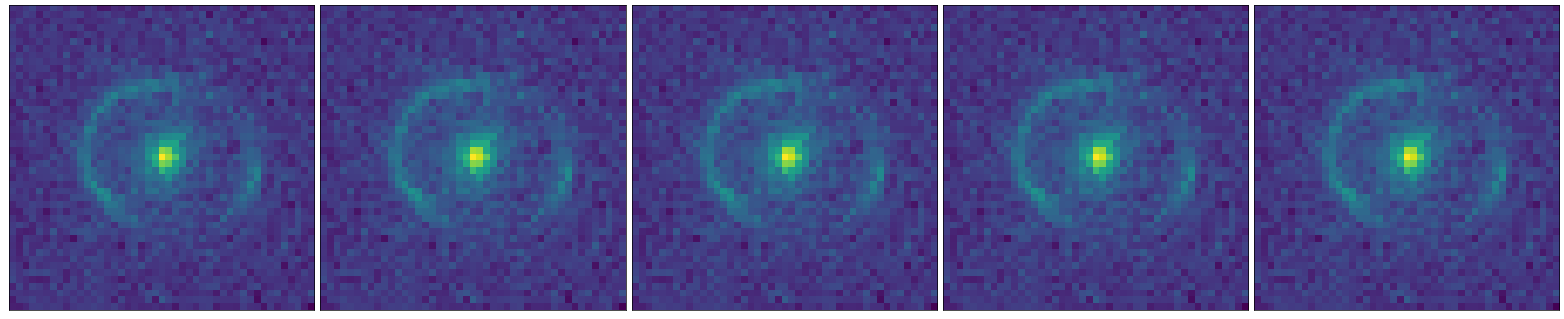

In [9]:
image_list = [pandeia_1, pandeia_3, pandeia_5, pandeia_7, pandeia_9]

f, ax = plt.subplots(nrows=1, ncols=len(image_list), figsize=(20, 4), gridspec_kw={'hspace': 0.02,'wspace':0.02})

for i, image in enumerate(image_list):
    image = np.arcsinh(image)
    image -= np.amin(image)
    image /= np.amax(image)
    ax[i].imshow(image, cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    
# plt.savefig(os.path.join(figure_dir, 'skypy_output_test.png'))
plt.show()

In [7]:
print(pandeia_1.shape)

(45, 45)


In [10]:
def get_norm(array_list):
    min_list, max_list = [], []
    for array in array_list:
        min_list.append(abs(np.min(array)))
        max_list.append(abs(np.max(array)))
    abs_min, abs_max = abs(np.min(min_list)), abs(np.max(max_list))
    limit = np.max([abs_min, abs_max])
    linear_width = np.abs(np.mean(np.concatenate(array_list)) + (0 * np.std(np.concatenate(array_list))))
    return colors.AsinhNorm(linear_width=0.0005, vmin=-limit, vmax=limit)

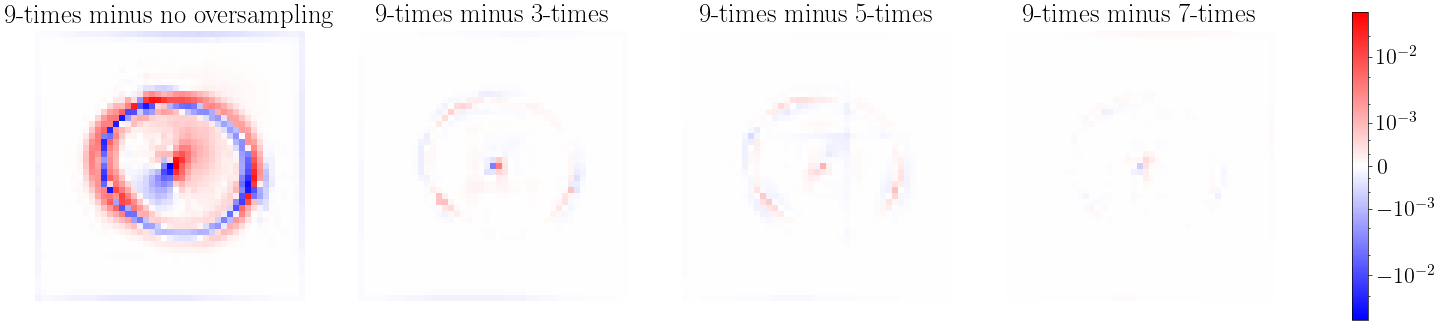

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
matplotlib.rcParams.update({'font.size': 16})

array_list = [pandeia_9 - pandeia_1, pandeia_9 - pandeia_3, pandeia_9 - pandeia_5, pandeia_9 - pandeia_7]
title_list = ['9-times minus no oversampling', '9-times minus 3-times', '9-times minus 5-times', '9-times minus 7-times']

norm = get_norm(array_list)

for i, array in enumerate(array_list):
    axis = ax[i].imshow(array, cmap='bwr', norm=norm)
    ax[i].set_title(title_list[i])
    ax[i].set_axis_off()

fig.colorbar(axis, ax=ax, ticks=[-0.01, -0.001, 0, 0.001, 0.01])

plt.savefig(os.path.join(figure_dir, 'oversampling.png'))
plt.show()